In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import cv2
import re
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import warnings

delta = 1
min_area = 100
max_area = 250
max_variation = 0.1

### Extract the images and bounding boxes from the dataset and store them in `images` and `boxes` dictionaries respectively.

In [19]:
## Read Images from 10 folders named (00001,00002,...,00010)
## Each folder contains images in .bmp format and a .txt file with the name groundtruth.txt
## groundtruth.txt contains the coordinates of the bounding box of the object in the image
## The images are of size 360x240

# Path to the folder containing the 10 folders
def read_images(path="./datasets/OTCBVS_Pedestrian"):
    # path = "./datasets/OTCBVS_Pedestrian"

    ## Extract Bounding Boxes from groundtruth.txt files
    # Loop over the 10 folders
    boxes = {}
    for i in range(1,11):
        # Path to the folder
        if i < 10:
            path_folder = path + "/0000" + str(i)
        else:
            path_folder = path + "/000" + str(i)
        # Path to the groundtruth.txt file
        path_txt = path_folder + "/groundTruth.txt"
        # Open the groundtruth.txt file
        txt = open(path_txt, "r")
        # Loop over the lines of the file
        for _ in range(4):
            next(txt)           # Skip the first 4 lines
        
        folder_boxes = []
        # Loop over the lines of the file
        for line in txt:
            box = []
            matches = re.findall(r'\((\d+) (\d+) (\d+) (\d+)\)', line)
            # Loop over the matches

            if matches:
                for match in matches:
                    # Extract the coordinates of the bounding box
                    x1, y1 , x2 , y2 = map(int, match)
                    # print("x1: ", x1, "y1: ", y1, "x2: ", x2, "y2: ", y2)
                    # Append the coordinates to the list
                    box.append([x1, y1, x2, y2])
            
            folder_boxes.append(box)
        
        if i < 10:
            boxes["0000" + str(i)] = folder_boxes
        else:
            boxes["000" + str(i)] = folder_boxes

        txt.close()

    # print(len(boxes["00001"]))

    ## Extract Images from .bmp files
    # Loop over the 10 folders
    images = {}
    for i in range(1,11):
        # Path to the folder
        if i < 10:
            path_folder = path + "/0000" + str(i)
        else:
            path_folder = path + "/000" + str(i)
        # Path to the .bmp files
        path_bmp = path_folder
        # List of the .bmp files
        bmp_files = os.listdir(path_bmp)
        # Sort the list of the .bmp files
        bmp_files.sort()
        # Loop over the .bmp files
        folder_images = []

        for bmp_file in bmp_files:
            if bmp_file.endswith(".bmp"):
                
                # Path to the .bmp file
                path_bmp_file = path_bmp + "/" + bmp_file
                # # Open the .bmp file
                # bmp = open(path_bmp_file, "rb")
                # # Read the .bmp file
                # bmp_data = bmp.read()
                # # Append the .bmp file to the list
                # folder_images.append(bmp_data)
                # bmp.close()
                image = cv2.imread(path_bmp_file)

                # Apply Image Enhancement
                # image = image_enhance(image)

                # Append the .bmp file to the list
                folder_images.append(image)

        if i < 10:
            images["0000" + str(i)] = folder_images
        else:
            images["000" + str(i)] = folder_images
            
    return images, boxes

images, boxes = read_images()

### Utility functions for getting the MSER regions from the images.

In [20]:
def image_enhance(x):
    # Convert to grayscale
    x_gray = cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)

    # Image sharpening
    kernel = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]], dtype=np.float32)
    y1 = cv2.filter2D(x_gray, -1, kernel)

    # Morphological opening
    se = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 15))
    background = cv2.morphologyEx(x_gray, cv2.MORPH_OPEN, se)
    y2 = cv2.subtract(x_gray, background)
    y2 = cv2.normalize(y2, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Histogram equalization
    y3 = cv2.equalizeHist(x_gray)

    # Deconvolution (you can adjust PSF and regularization parameters as needed)
    PSF = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], dtype=np.float32)
    y4 = cv2.filter2D(x_gray, -1, PSF)

    # Weighted average of enhanced images
    y = cv2.addWeighted(y1, 0.25, y2, 0.25, 0)
    y = cv2.addWeighted(y, 0.25, y3, 0.25, 0)
    y = cv2.addWeighted(y, 0.25, y4, 0.25, 0)

    return y

# get MSER regions
def getMSERregions(img):
    # create MSER object
    mser = cv2.MSER_create(delta = delta, min_area = min_area, max_area = max_area, max_variation = max_variation)
    # detect MSER regions
    regions, mser_bboxes = mser.detectRegions(img)
    # get bounding boxes from regions
    bboxes = []
    for region in regions:
        x, y, w, h = cv2.boundingRect(region)
        bboxes.append([x, y, x+w, y+h])
    return bboxes , mser_bboxes

def getMSERregionsAll(images,dataset="OTCBVS_Pedestrian"):
    # create dictionary to store MSER regions
    regions = {}
    # loop over all images

    if dataset == "OTCBVS_Pedestrian":
        for key in images.keys():
            # create list to store MSER regions
            regions[key] = []
            # loop over all images in folder
            for img in images[key]:
                # convert image to grayscale
                img = image_enhance(img)
                # get MSER regions
                bboxes , mser_bboxes = getMSERregions(img)
                # append MSER regions to list
                regions[key].append(bboxes)
    elif dataset == "ASL-TID":
        for key in images.keys():
            # create list to store MSER regions
            regions[key] = []
            # convert image to grayscale
            img = image_enhance(images[key])
            # get MSER regions
            bboxes , mser_bboxes = getMSERregions(img)
            # append MSER regions to list
            regions[key] = bboxes
    return regions

### Extract the MSERs from the images and store them in `regions` dictionary

Image 0 : img_00001.bmp
img_00001.bmp
No. of boxes in image 0 : 5
No. of boxes in image 0 : 5
No. of boxes in image 0 : 5
No. of boxes in image 0 : 5
No. of boxes in image 0 : 5


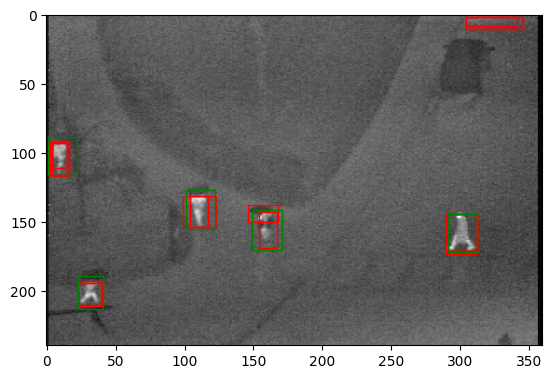

Image 0 : img_00001.bmp
img_00001.bmp
No. of boxes in image 0 : 4
No. of boxes in image 0 : 4
No. of boxes in image 0 : 4
No. of boxes in image 0 : 4


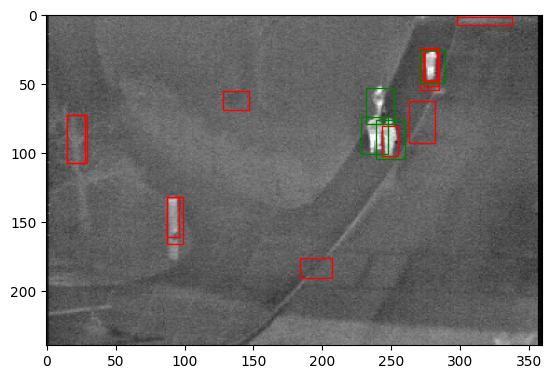

Image 0 : img_00001.bmp
img_00001.bmp
No. of boxes in image 0 : 5
No. of boxes in image 0 : 5
No. of boxes in image 0 : 5
No. of boxes in image 0 : 5
No. of boxes in image 0 : 5


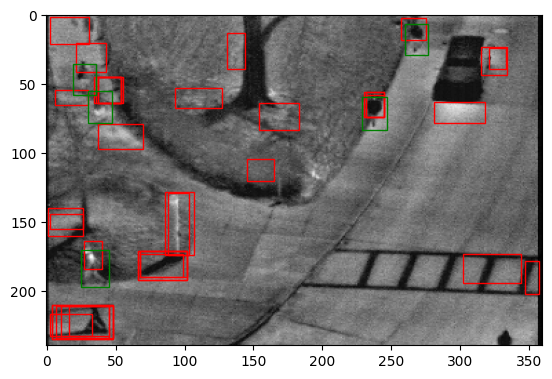

Image 0 : img_00001.bmp
img_00001.bmp
No. of boxes in image 0 : 4
No. of boxes in image 0 : 4
No. of boxes in image 0 : 4
No. of boxes in image 0 : 4


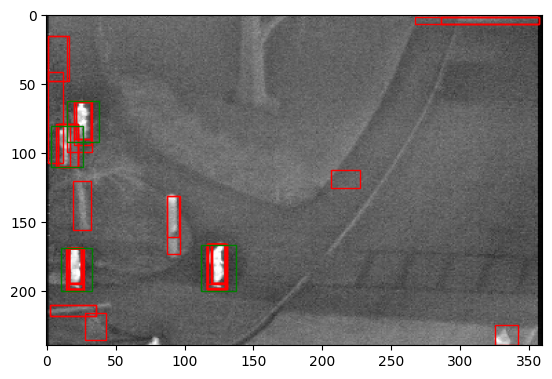

Image 0 : img_00001.bmp
img_00001.bmp
No. of boxes in image 0 : 2
No. of boxes in image 0 : 2


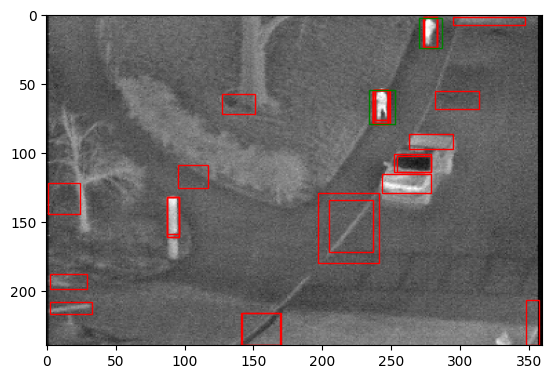

Image 0 : img_00001.bmp
img_00001.bmp
No. of boxes in image 0 : 8
No. of boxes in image 0 : 8
No. of boxes in image 0 : 8
No. of boxes in image 0 : 8
No. of boxes in image 0 : 8
No. of boxes in image 0 : 8
No. of boxes in image 0 : 8
No. of boxes in image 0 : 8


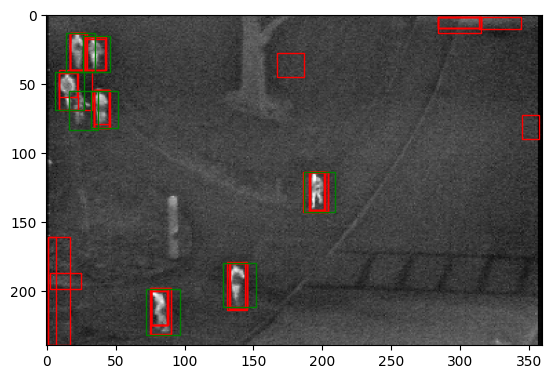

Image 0 : img_00001.bmp
img_00001.bmp
No. of boxes in image 0 : 2
No. of boxes in image 0 : 2


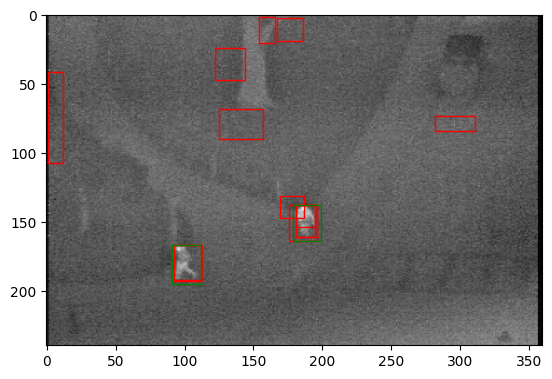

Image 0 : img_00001.bmp
img_00001.bmp
No. of boxes in image 0 : 4
No. of boxes in image 0 : 4
No. of boxes in image 0 : 4
No. of boxes in image 0 : 4


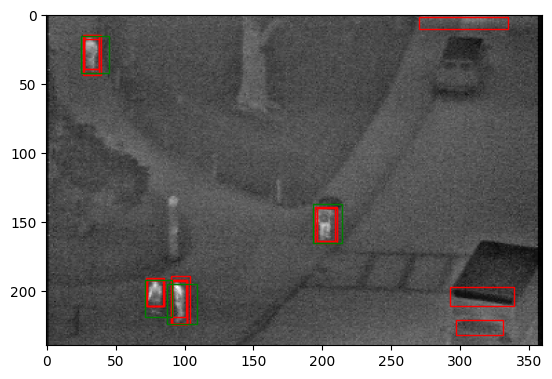

Image 0 : img_00001.bmp
img_00001.bmp
No. of boxes in image 0 : 1


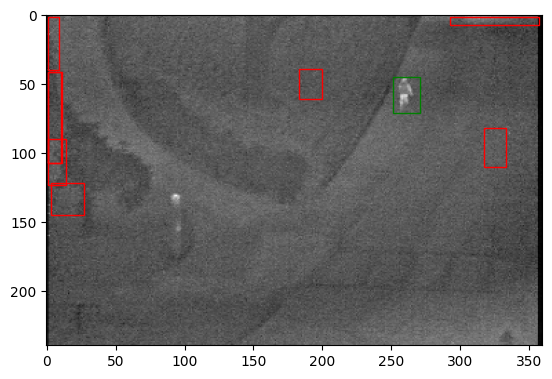

Image 0 : img_00001.bmp
img_00001.bmp
No. of boxes in image 0 : 6
No. of boxes in image 0 : 6
No. of boxes in image 0 : 6
No. of boxes in image 0 : 6
No. of boxes in image 0 : 6
No. of boxes in image 0 : 6


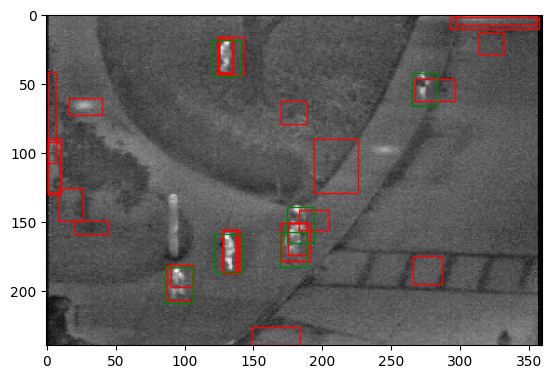

In [21]:
### Visualize images

# Path to the folder
path="./datasets/OTCBVS_Pedestrian"

# Get images and bounding boxes
images, boxes = read_images(path)

# Get MSER regions
regions = getMSERregionsAll(images,"OTCBVS_Pedestrian")

# Loop over the 10 folders
for i in range(1, 11):
    # Path to the folder
    if i < 10:
        path_folder = path + "/0000" + str(i)
        key = "0000" + str(i)
    else:
        path_folder = path + "/000" + str(i)
        key = "000" + str(i)
    # Path to the .bmp files
    path_bmp = path_folder
    # List of the .bmp files
    list_bmp = os.listdir(path_bmp)

    list_bmp.sort()
    list_bmp.pop(0)
    list_bmp.pop(0)
    # Loop over the .bmp files
    # print(len(boxes[key]))
    for j in range(0,len(boxes[key])):
        print("Image " + str(j) + " : " + list_bmp[j])
        if list_bmp[j].endswith(".bmp"):
            # Path to the .bmp file
            print(list_bmp[j])
            path_bmp_file = path_bmp + "/" + list_bmp[j]
            # Read the .bmp file
            img = cv2.imread(path_bmp_file)
            # Convert image to grayscale
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Create figure and axes
            fig, ax = plt.subplots(1)
            # Display the image
            ax.imshow(img, cmap='gray')
            # Loop over the MSER regions

            for region in regions[key][j]:
                # Create a Rectangle patch
                rect1 = patches.Rectangle((region[0],region[1]),region[2]-region[0],region[3]-region[1],linewidth=1,edgecolor='r',facecolor='none')
                # Add the patch to the Axes
                ax.add_patch(rect1)
            # Loop over the groundtruth bounding boxes
            for box in boxes[key][j]:
                # Create a Rectangle patch
                print("No. of boxes in image " + str(j) + " : " + str(len(boxes[key][j])))
                rect2 = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=1,edgecolor='g',facecolor='none')
                # Add the patch to the Axes
                ax.add_patch(rect2)
            # Display the figure
            
            plt.show()
            # Close the figure
            plt.close(fig)

        break



### Utility functions for feature extraction

In [22]:
# Regions are present in Regions, and the ground truth bounding boxes are present in boxes

# Write a function to take the IOU threshold and return, 1 or 0
def IOU(Region, Boxes, threshold=0.5):
    Region = np.array(Region)
    Boxes = np.array(Boxes)

    for box in Boxes:
        x1, y1, x2, y2 = box[0], box[1], box[2], box[3]
        # Find the coordinates of the intersection rectangle, for the region and the box
        xA = max(Region[0], x1)
        yA = max(Region[1], y1)
        xB = min(Region[2], x2)
        yB = min(Region[3], y2)

        # Compute the area of intersection rectangle
        interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

        # Compute the area of both the rectangles
        boxArea = (x2 - x1 + 1) * (y2 - y1 + 1)

        # Compute the IOU
        iou = interArea / float(boxArea)

        if iou >= threshold:
            return 1
        
    return 0

# For the given image, find the number of regions that have IOU >= 0.5
def getRegions(image, Regions, Boxes, threshold=0.5):
    Regions = np.array(Regions)
    Boxes = np.array(Boxes)
    labels = []
    for region in Regions:
        labels.append(IOU(region, Boxes, threshold))
    return labels

def deriveFeatures(regions, key, j):
    feature_images = []
    Gx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=float)
    Gy = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=float)
    for region in regions[key][j]:
        x, y, w, h = region[0], region[1], region[2]-region[0], region[3]-region[1]
        hot_spot = img[y:y+h, x:x+w]
        hot_spot = cv2.resize(hot_spot, (16, 32), interpolation=cv2.INTER_LINEAR)
        gradient_images = []
        for angle in range(0, 180, 30):
            M = cv2.getRotationMatrix2D((hot_spot.shape[1] / 2, hot_spot.shape[0] / 2), angle, 1)
            rotated_hot_spot = cv2.warpAffine(hot_spot, M, (hot_spot.shape[1], hot_spot.shape[0]))
            Gx_image = cv2.filter2D(rotated_hot_spot, -1, Gx).astype(np.float32)
            Gy_image = cv2.filter2D(rotated_hot_spot, -1, Gy).astype(np.float32)
            gradient_magnitude = cv2.magnitude(Gx_image, Gy_image)
            gradient_images.append(gradient_magnitude)
        descriptor = []
        for i in range(2000):
            x = np.random.randint(0, 31)
            y = np.random.randint(0, 15)
            rand_i = np.random.randint(1, 8)
            width = np.random.randint(1, 16 - y)
            height = np.random.randint(1, 32 - x)
            local_sums = 0
            for gradient_image in gradient_images:
                region = gradient_image[y:y+height, x:x+width]
                local_sums += np.sum(region)
            descriptor.append(local_sums)
        feature_images.append(descriptor)   
    return feature_images

# Initialize the list of features and labels
image_features_f = np.empty((0,2000))
labels_f = np.empty((0,1))
labels_f = labels_f.reshape(-1, 1)

# Loop over the 10 folders
for i in range(1,11):
    # Path to the folder
    if i < 10:
        path_folder = path + "/0000" + str(i)
        key = "0000" + str(i)
    else:
        path_folder = path + "/000" + str(i)
        key = "000" + str(i)
    # Path to the .bmp files
    path_bmp = path_folder
    # List of the .bmp files
    list_bmp = os.listdir(path_bmp)

    list_bmp.sort()
    list_bmp.pop(0)
    list_bmp.pop(0)

    # Loop over the .bmp files
    # print(len(boxes[key]))
    for j in range(0,len(boxes[key])):
        print("Image " + str(j) + " : " + list_bmp[j])
        if list_bmp[j].endswith(".bmp"):
            # Path to the .bmp file
            print(list_bmp[j])
            path_bmp_file = path_bmp + "/" + list_bmp[j]
            # Read the .bmp file
            img = cv2.imread(path_bmp_file)
            # Convert image to grayscale
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            # Create figure and axes
            # fig, ax = plt.subplots(1)
            # Display the image
            # ax.imshow(img, cmap='gray')

            label_regions = getRegions(img, regions[key][j], boxes[key][j], threshold=0.5)

            # Loop over the MSER regions
            for region in regions[key][j]:
                # Create a Rectangle patch
                # rect1 = patches.Rectangle((region[0],region[1]),region[2]-region[0],region[3]-region[1],linewidth=1,edgecolor='r',facecolor='none')
                # Add the patch to the Axes
                ax.add_patch(rect1)
            # Loop over the groundtruth bounding boxes
            for box in boxes[key][j]:
                # Create a Rectangle patch
                print("No. of boxes in image " + str(j) + " : " + str(len(boxes[key][j])))
                # rect2 = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=1,edgecolor='g',facecolor='none')
                # Add the patch to the Axes
                ax.add_patch(rect2)
            # Display the figure
            # Loop over the MSER regions, but if the region has IOU >= 0.5, then color it blue
            for i in range(len(regions[key][j])):
                if label_regions[i] == 1:
                    region = regions[key][j][i]
                    # rect1 = patches.Rectangle((region[0],region[1]),region[2]-region[0],region[3]-region[1],linewidth=1,edgecolor='b',facecolor='none')
                    ax.add_patch(rect1)

            # Derive the features for the regions
            feature_images = deriveFeatures(regions, key, j)
            feature_images = np.array(feature_images)

            print("Shape of the Image Features", feature_images.shape)

            # Add the features to the list and concatenate them in the axis = 0
            image_features_f = np.concatenate((image_features_f, feature_images), axis=0)

            print("labels_f.shape", labels_f.shape)
            print("np.array(label_regions).shape", np.array(label_regions).reshape(-1, 1).shape)

            # Add the labels to the list and concatenate them in the axis = 0
            labels_f = np.concatenate((labels_f, np.array(label_regions).reshape(-1, 1)), axis=0)

            # Print out the size of the features and labels
            print("Size of features: ", (image_features_f).shape)
            # print("Size of labels: ", len(labels_f))

            # plt.show()
            # # Close the figure
            # plt.close(fig)



Image 0 : img_00001.bmp
img_00001.bmp
No. of boxes in image 0 : 5
No. of boxes in image 0 : 5
No. of boxes in image 0 : 5
No. of boxes in image 0 : 5
No. of boxes in image 0 : 5
Shape of the Image Features (19, 2000)
labels_f.shape (0, 1)
np.array(label_regions).shape (19, 1)
Size of features:  (19, 2000)
Image 1 : img_00002.bmp
img_00002.bmp
No. of boxes in image 1 : 5
No. of boxes in image 1 : 5
No. of boxes in image 1 : 5
No. of boxes in image 1 : 5
No. of boxes in image 1 : 5
Shape of the Image Features (26, 2000)
labels_f.shape (19, 1)
np.array(label_regions).shape (26, 1)
Size of features:  (45, 2000)
Image 2 : img_00003.bmp
img_00003.bmp
No. of boxes in image 2 : 1
Shape of the Image Features (11, 2000)
labels_f.shape (45, 1)
np.array(label_regions).shape (11, 1)
Size of features:  (56, 2000)
Image 3 : img_00004.bmp
img_00004.bmp
No. of boxes in image 3 : 1
Shape of the Image Features (11, 2000)
labels_f.shape (56, 1)
np.array(label_regions).shape (11, 1)
Size of features:  (67,

In [23]:
# Ignore warnings
warnings.filterwarnings('ignore')

class ClassifierModels:
    def __init__(self, X, y):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        self.naive_bayes = GaussianNB()
        self.svm_classifier_linear = make_pipeline(StandardScaler(), SVC(kernel='linear'))
        self.svm_classifier_rbf = make_pipeline(StandardScaler(), SVC(kernel='rbf'))

    def train_naive_bayes(self):
        self.naive_bayes.fit(self.X_train, self.y_train)

    def train_svm_classifier(self):
        self.svm_classifier_linear.fit(self.X_train, self.y_train)
        self.svm_classifier_rbf.fit(self.X_train, self.y_train)

    def evaluate_naive_bayes(self):
        y_pred_nb = self.naive_bayes.predict(self.X_test)
        accuracy_nb = accuracy_score(self.y_test, y_pred_nb)
        precision_nb = precision_score(self.y_test, y_pred_nb)
        recall_nb = recall_score(self.y_test, y_pred_nb)
        f1_nb = f1_score(self.y_test, y_pred_nb)
        classification_report_nb = classification_report(self.y_test, y_pred_nb)
        return {
            "accuracy": accuracy_nb,
            "precision": precision_nb,
            "recall": recall_nb,
            "f1_score": f1_nb,
            "classification_report": classification_report_nb
        }

    def evaluate_svm_classifier_linear(self):
        y_pred_svm = self.svm_classifier_linear.predict(self.X_test)
        
        accuracy_svm = accuracy_score(self.y_test, y_pred_svm)
        precision_svm = precision_score(self.y_test, y_pred_svm)
        recall_svm = recall_score(self.y_test, y_pred_svm)
        f1_svm = f1_score(self.y_test, y_pred_svm)
        classification_report_svm = classification_report(self.y_test, y_pred_svm)
        return {
            "accuracy": accuracy_svm,
            "precision": precision_svm,
            "recall": recall_svm,
            "f1_score": f1_svm,
            "classification_report": classification_report_svm
        }
    
    def evaluate_svm_classifier_rbf(self):
        y_pred_svm = self.svm_classifier_rbf.predict(self.X_test)
        
        accuracy_svm = accuracy_score(self.y_test, y_pred_svm)
        precision_svm = precision_score(self.y_test, y_pred_svm)
        recall_svm = recall_score(self.y_test, y_pred_svm)
        f1_svm = f1_score(self.y_test, y_pred_svm)
        classification_report_svm = classification_report(self.y_test, y_pred_svm)
        return {
            "accuracy": accuracy_svm,
            "precision": precision_svm,
            "recall": recall_svm,
            "f1_score": f1_svm,
            "classification_report": classification_report_svm
        }

    def predict_single_sample(self, sample, model='nb'):
        if model == 'nb':
            return self.naive_bayes.predict([sample])
        elif model == 'svm_l':
            return self.svm_classifier_linear.predict([sample])
        elif model == 'svm_rbf':
            return self.svm_classifier_rbf.predict([sample])
        else:
            return None

X = image_features_f
y = labels_f

# Create the classifier models object
classifier_models = ClassifierModels(X, y)

# Train the Naive Bayes classifier
classifier_models.train_naive_bayes()

# Evaluate the Naive Bayes classifier
naive_bayes_metrics = classifier_models.evaluate_naive_bayes()

# Train the SVM classifier
classifier_models.train_svm_classifier()

# Evaluate the SVM-Linear classifier
svm_classifier_metrics_l = classifier_models.evaluate_svm_classifier_linear()

# Evaluate the SVM-RBF classifier
svm_classifier_metrics_rbf = classifier_models.evaluate_svm_classifier_rbf()

# Display the evaluation metrics
print("Naive Bayes Classifier Metrics:")
print(naive_bayes_metrics)

print("SVM with Linear Kernel Classifier Metrics:")
print(svm_classifier_metrics_l)

print("SVM with RBF Kernel Classifier Metrics:")
print(svm_classifier_metrics_rbf)

Naive Bayes Classifier Metrics:
{'accuracy': 0.8299319727891157, 'precision': 0.7656675749318801, 'recall': 0.878125, 'f1_score': 0.8180494905385735, 'classification_report': '              precision    recall  f1-score   support\n\n         0.0       0.89      0.79      0.84       830\n         1.0       0.77      0.88      0.82       640\n\n    accuracy                           0.83      1470\n   macro avg       0.83      0.84      0.83      1470\nweighted avg       0.84      0.83      0.83      1470\n'}
SVM with Linear Kernel Classifier Metrics:
{'accuracy': 0.710204081632653, 'precision': 0.6813559322033899, 'recall': 0.628125, 'f1_score': 0.653658536585366, 'classification_report': '              precision    recall  f1-score   support\n\n         0.0       0.73      0.77      0.75       830\n         1.0       0.68      0.63      0.65       640\n\n    accuracy                           0.71      1470\n   macro avg       0.71      0.70      0.70      1470\nweighted avg       0.71

## Basically after this, we need to find out the ground truths, and see which IOU's match the most, and wherever we 

In [ ]:
# def read_images(path="./datasets/ASL-TID", folder="train"):
#     ## Extract Bounding Boxes from labelTxt files
#     # Path to the folder
#     path_folder = path + "/" + folder
#     # Path to the labelTxt folder
#     path_labelTxt = path_folder + "/labels"
#     # Path to the images folder
#     path_images = path_folder + "/images"

#     # Loop over the images folder
#     images = {}

#     image_list = os.listdir(path_images)
#     image_list.sort()

#     for filename in image_list:
#         # Path to the image
#         path_image = path_images + "/" + filename
#         # Read the image

#         filename = filename[:-4]            # Remove the .jpg extension

#         image = cv2.imread(path_image)
#         # Append the image to the list
#         images[filename] = image
    
#     # Loop over the labelTxt folder
#     # Format of the labelTxt file: <class> <x_center> <y_center> <width> <height>   in normalized format 
#     all_boxes = {}

#     bbox_list = os.listdir(path_labelTxt)
#     bbox_list.sort()

#     for filename in bbox_list:
#         # Path to the labelTxt file
#         path_txt = path_labelTxt + "/" + filename
#         # Open the labelTxt file
#         txt = open(path_txt, "r")

#         filename = filename[:-4]            # Remove the .txt extension
        
#         # Loop over the lines of the file

#         file_boxes = []

#         lines = txt.readlines()

#         matches = []
        
#         for line in lines:
#             temp = line.strip().split(" ")
#             temp = temp[1:]
#             # convert to int
#             temp = [float(i) for i in temp]

#             matches.append(temp)

#         # print(matches)

        
#         # Loop over the matches
#         if matches:
#             for match in matches:
#                 # Extract the coordinates of the bounding box
#                 box = []
#                 center_x = match[0]
#                 center_y = match[1]
#                 width = match[2]
#                 height = match[3]

#                 # print("center_x: ", center_x, "center_y: ", center_y, "width: ", width, "height: ", height)
#                 # Multiply with Image size to get the coordinates in pixels - 416x416
#                 x1 = (center_x - width/2) * 416
#                 y1 = (center_y - height/2) * 416
#                 x2 = (center_x + width/2) * 416
#                 y2 = (center_y + height/2) * 416
#                 if(x1 < 0):
#                     x1 = 0
#                 if(y1 < 0):
#                     y1 = 0
#                 if(x2 >= 416):
#                     x2 = 415
#                 if(y2 >= 416):
#                     y2 = 415
#                 # print("x1: ", x1, "y1: ", y1, "x2: ", x2, "y2: ", y2)

#                 # Convert to int
#                 x1 = int(x1)
#                 y1 = int(y1)
#                 x2 = int(x2)
#                 y2 = int(y2)
#                 # Append the coordinates to the list
#                 box.append(x1)
#                 box.append(y1)
#                 box.append(x2)
#                 box.append(y2)

#             file_boxes.append(box)
        
#         all_boxes[filename] = file_boxes
#         txt.close()
    


#     return images, all_boxes

In [ ]:

# images, boxes = read_images("./datasets/ASL-TID/", "train")

# regions = getMSERregionsAll(images,"ASL-TID")

# path = "./datasets/ASL-TID"

# path_folder = path + "/" + "train"
# # Path to the labelTxt folder
# path_labelTxt = path_folder + "/labels"
# # Path to the images folder
# path_images = path_folder + "/images"

# # Loop over the images folder

# image_list = os.listdir(path_images)
# image_list.sort()

# i = 0

# for filename in image_list:

#     if i == 20:
#         break

#     i = i + 1
#     # Path to the image
#     path_image = path_images + "/" + filename
#     # Read the image
#     filename = filename[:-4]            # Remove the .jpg extension

#     image = images[filename]
#     # Convert image to grayscale
#     img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
#     # Create figure and axes
#     fig, ax = plt.subplots(1)
#     # Display the image
#     ax.imshow(img, cmap='gray')
#     # Loop over the MSER regions
    

#     for region in regions[filename]:
#         # Create a Rectangle patch
#         rect1 = patches.Rectangle((region[0],region[1]),region[2]-region[0],region[3]-region[1],linewidth=1,edgecolor='r',facecolor='none')
#         # Add the patch to the Axes
#         ax.add_patch(rect1)
#     # Loop over the groundtruth bounding boxes
#     for box in boxes[filename]:
#         # Create a Rectangle patch
#         print(box)
#         rect2 = patches.Rectangle((box[0],box[1]),box[2]-box[0],box[3]-box[1],linewidth=1,edgecolor='g',facecolor='none')
#         # Add the patch to the Axes
#         ax.add_patch(rect2)

#     # Display the figure
#     plt.show()
#     # Close the figure
#     plt.close(fig)